In [34]:
import numpy as np
import time
from math import sqrt, pi, exp
import functools
import scipy
import matplotlib.pylab as pl
from varname import nameof

from scipy.stats import multivariate_normal

from utils.preconditioners import *
from utils.algorithms import *
from utils.functions import *

matplotlib.rcParams.update({'font.size': 18})


import numpy as np

import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.proj3d import proj_transform
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib.patches import FancyArrowPatch


class Arrow3D(FancyArrowPatch):

    def __init__(self, x, y, z, dx, dy, dz, *args, **kwargs):
        super().__init__((0, 0), (0, 0), *args, **kwargs)
        self._xyz = (x, y, z)
        self._dxdydz = (dx, dy, dz)

    def draw(self, renderer):
        x1, y1, z1 = self._xyz
        dx, dy, dz = self._dxdydz
        x2, y2, z2 = (x1 + dx, y1 + dy, z1 + dz)

        xs, ys, zs = proj_transform((x1, x2), (y1, y2), (z1, z2), self.axes.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        super().draw(renderer)
        
    def do_3d_projection(self, renderer=None):
        x1, y1, z1 = self._xyz
        dx, dy, dz = self._dxdydz
        x2, y2, z2 = (x1 + dx, y1 + dy, z1 + dz)

        xs, ys, zs = proj_transform((x1, x2), (y1, y2), (z1, z2), self.axes.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))

        return np.min(zs) 
    
def _arrow3D(ax, x, y, z, dx, dy, dz, *args, **kwargs):
    '''Add an 3d arrow to an `Axes3D` instance.'''

    arrow = Arrow3D(x, y, z, dx, dy, dz, *args, **kwargs)
    ax.add_artist(arrow)


setattr(Axes3D, 'arrow3D', _arrow3D)


### Test case "Mixture of Gaussians" - 1 

(-6.0, 6.0, -6.0, 6.0)

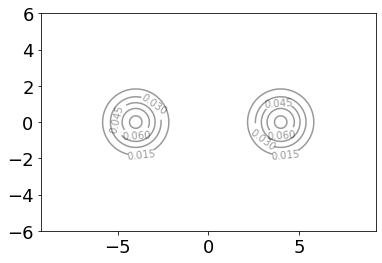

In [35]:
d = 2

val = 6
xmin = -val
xmax = val
ymin= -val
ymax= val


sigma1 = 1
sigma2 = 1
gap = 8

# target density
def bimodal_distribution(z, gap = gap, sigma1 = sigma1, sigma2 = sigma2):
    # Bimodal distribution probability density function
    mean1 = [-gap/2, 0]
    cov1 = [[sigma1, 0], [0, sigma1]]
    pdf1 = multivariate_normal(mean1, cov1).pdf(z)

    mean2 = [gap/2, 0]
    
    cov2 = [[sigma2, 0], [0, sigma2]]
    pdf2 = multivariate_normal(mean2, cov2).pdf(z)

    outcome= 0.5 * pdf1 + 0.5 * pdf2
    return outcome

# target potential
def potential(z):
    return -np.log(bimodal_distribution(z))


nb_grid = 200


# plot posterior
u0s = np.linspace(xmin, xmax, nb_grid) # draw a grid of nb_grid points in 2d
u1s = np.linspace(ymin, ymax, nb_grid)
U0, U1 = np.meshgrid(u0s,u1s)
U = np.dstack((U0,U1)) # size (2, nb_grid, nb_grid)

unnorm_dens = bimodal_distribution(U) #np.exp(-I1(U)) + np.exp(-I2(U))

Z = np.trapz(unnorm_dens, u0s, axis=1)
Z = np.trapz(Z, u1s)
dens = unnorm_dens/Z 
#marg_over_x = np.trapz(dens, u0s, axis=1)
#marg_over_y = np.trapz(dens, u1s, axis=0)

plt.figure()
DS = plt.contour(U0, U1, np.exp(-potential(U)), 5, alpha=0.4, colors="black")
plt.clabel(DS, inline=1, fontsize=10) # level sets of target
plt.axis('equal')

In [3]:
U.shape

(200, 200, 2)

[-0. -0.]
(15, 2)


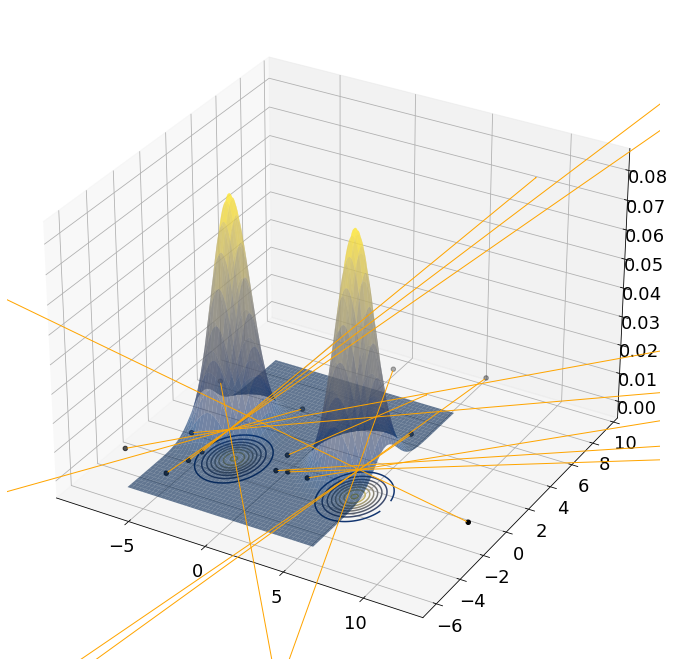

In [36]:
#m1 = np.asarray([-1, 0]).reshape((2,1))
#m2 = np.asarray([1, 0]).reshape((2,1))
#I1 = lambda u: 0.5/(sigma**2)*((u[0] - gap/2)**2 + u[1]**2) # TODO: recoder ça bien
#I2 = lambda u: 0.5/(sigma**2)*((u[0] + gap/2)**2 + u[1]**2)
#I = lambda u: - np.log(np.exp(-I1(u)) + np.exp(-I2(u)))


#not vectorized
def gradient_of_log_bimodal_distribution(z, gap = gap, sigma1 = sigma1, sigma2 = sigma2):

    mean1 = np.asarray([-gap/2, 0])
    cov1 = [[sigma1, 0], [0, sigma1]]
    pdf1 = multivariate_normal(mean1, cov1).pdf(z) 
    

    mean2 = np.asarray([gap/2, 0])
    cov2 = [[sigma2, 0], [0, sigma2]]
    pdf2 = multivariate_normal(mean2, cov2).pdf(z)

    gradient= - (1/(bimodal_distribution(z)))*(0.5*pdf1*np.matmul(np.linalg.inv(cov1),(z - mean1))\
                                                     +0.5*pdf2*np.matmul(np.linalg.inv(cov2),(z - mean2)))
    return gradient


test = np.zeros(2)
print(gradient_of_log_bimodal_distribution(test))
#plt.figure()
#DS = plt.contour(U0, U1, gradient_of_log_bimodal_distribution(U), 5, alpha=0.4, colors="black") # does not work
# Plot the particles with direction arrows

X, Y = U0, U1
Z = dens
np.random.seed(5)
num_particles = 15
particles = np.random.normal(0, 5, size=(num_particles, 2))
grad_particles = np.zeros_like(particles)
for i in range(num_particles):
        for j in range(num_particles):
            grad_particles[i] +=  gradient_of_log_bimodal_distribution(particles[i,:])
print(grad_particles.shape)

fig = plt.figure(figsize=(20, 12))
ax = fig.add_subplot(111, projection='3d')
# Plot the surface of the bimodal distribution
ax.plot_surface(X, Y, Z, cmap= 'cividis', edgecolor='none', alpha=0.6)

# Create a contour plot in the horizontal plane
ax.contour(X, Y, Z, levels=8, zdir="z", offset=-0.01, cmap='cividis')
ax.scatter(particles[:, 0], particles[:, 1], np.zeros_like(particles[:, 0]), color='black', label='Particles',zorder=160)
# ax.quiver(particles[:, 0], particles[:, 1], np.zeros_like(particles[:, 0]), grad_particles[:, 0], grad_particles[:, 1], np.zeros_like(particles[:, 0]),
#           color='red', label='Update Direction', alpha=0.8, arrow_length_ratio=0.05,length=5)

# Plot the arrows using Arrow3D
for xi, yi, zi, dxi, dyi, dzi in zip(particles[:, 0], particles[:, 1], np.zeros_like(particles[:, 0]), grad_particles[:, 0], grad_particles[:, 1], np.zeros_like(particles[:, 0])):
    arrow=Arrow3D(xi, yi, zi, xi+dxi, yi+dyi, zi+dzi,mutation_scale=1, arrowstyle='->', lw=1, color='orange',zorder=21,shrinkA=2,shrinkB=2,label='kaas')
    ax.add_artist(arrow)

In [37]:
# try ula

# parameters of all the algorithms

J = 20  # number of particles 
N_sim = 1000 # number of iterations
d = 2 # dimension
tau = 1e-2 # step size

# parameters of our algorithm
const = 1.5 

# independent Langevin sampler (independent particles)
#  number of iterations, initialization
def run_ULA_mog(potential, N_sim, u0, tau, grad_inference = gradient_of_log_bimodal_distribution):
    
    d, J  = u0.shape

    us_list_ULA = np.zeros((d, J, N_sim)) 
    us_list_ULA[:,:,0] = u0 
    
    
    for n in range(N_sim-1):    
        us = us_list_ULA[:,:,n]
        #print(us.shape) # (d, J)
        #print(us.shape[1]) # = J
        
        vs = np.zeros_like(us)
        for i in range(us.shape[1]):
            test = gradient_of_log_bimodal_distribution(us[:, i])#.reshape((2,1))
            vs[:, i] +=  gradient_of_log_bimodal_distribution(us[:, i])#.reshape((2,1))

        us_list_ULA[:,:,n+1] = us_list_ULA[:,:,n] + tau*vs \
            + np.sqrt(2*tau)*np.random.normal(0,1,(d,J))

    return us_list_ULA


I = lambda u: potential(np.stack((u[0],u[1]),axis=-1))

N_exp = 1

for j in range(N_exp):
    
    print()
    print("Experiment " +str(j))
    # resample initialization
    u0 = np.random.normal(0,2.0,(d,J)) 
    
    # ULA
    
    start_time = time.time()
    us_list_ULA = run_ULA_mog(I, N_sim, u0, tau)
    #np.save('save_data/mog/ULA_J_'+str(us_list_ULA.shape[1])+'_Nsim_'\
    #        +str(us_list_ULA.shape[2])+'_tau_'+str(tau)+'_Exp_'+str(j)+'.npy', us_list_ULA)
    print(f"ULA: {time.time()-start_time} seconds")

   


Experiment 0
ULA: 19.262065887451172 seconds


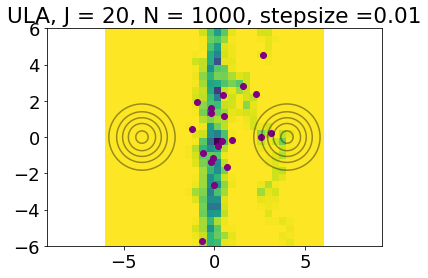

In [23]:
name = nameof(us_list_ULA).lstrip('us_list')

us_list = us_list_ULA
N_burnin = 0

binsx = np.linspace(xmin,xmax,31)
binsy = np.linspace(ymin,ymax,31)
H, yedges, xedges = np.histogram2d(us_list[0,:,N_burnin:].flatten(),us_list[1,:,N_burnin:].flatten(), bins=[binsx,binsy])
plt.figure()
plt.pcolormesh(yedges, xedges, H.T, cmap=pl.cm.viridis_r); #, cmap=pl.cm.viridis_r 


u0s = np.linspace(xmin,xmax,150)
u1s = np.linspace(ymin,ymax,150)
U0, U1 = np.meshgrid(u0s,u1s)
U = np.stack((U0,U1))
plt.contour(U0, U1, np.exp(-I(U)), 5, alpha=0.4, colors="black") #

J, N_sim = us_list.shape[1], us_list.shape[2]
#algo = nameof(us_list)
#print(algo)
plt.title(name+ ', J = '+str(J)+", N = "+str(N_sim) +", stepsize ="+str(tau))
plt.xlim((xmin,xmax))
plt.ylim((ymin,ymax))
plt.axis('equal')



#plot_results(I, us_list_ULA, tau, name, xmin =  -val, xmax = val, ymin = -val, ymax = val)
plt.scatter(us_list_ULA[0, :, 0], us_list_ULA[1, :, 0],  color = "purple", label = 'initial')
plt.scatter(us_list_ULA[0, :, -1], us_list_ULA[1, :, -1], color = "red", label = 'final')
plt.show()


In [7]:
# try ula

# parameters of all the algorithms

J = 20  # number of particles 
N_sim = 1000 # number of iterations
d = 2 # dimension
tau = 1e-2 # step size

# parameters of our algorithm
const = 1.5 

# independent Langevin sampler (independent particles)
#  number of iterations, initialization



N_exp = 1

for j in range(N_exp):
    
    print()
    print("Experiment " +str(j))
    # resample initialization
    u0 = np.random.normal(0,2.0,(d,J)) 
    
    # ULA
    
    start_time = time.time()
    us_list_ULA = run_ULA(I, N_sim, u0, tau)
    #np.save('save_data/mog/ULA_J_'+str(us_list_ULA.shape[1])+'_Nsim_'\
    #        +str(us_list_ULA.shape[2])+'_tau_'+str(tau)+'_Exp_'+str(j)+'.npy', us_list_ULA)
    print(f"ULA: {time.time()-start_time} seconds")

   


Experiment 0
ULA: 15.344296932220459 seconds


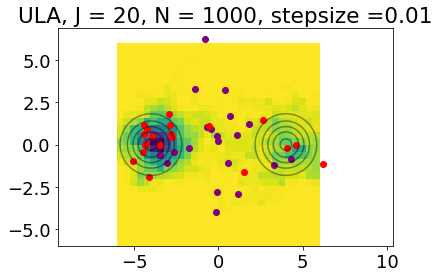

In [8]:
name = nameof(us_list_ULA).lstrip('us_list')

us_list = us_list_ULA
N_burnin = 0

binsx = np.linspace(xmin,xmax,31)
binsy = np.linspace(ymin,ymax,31)
H, yedges, xedges = np.histogram2d(us_list[0,:,N_burnin:].flatten(),us_list[1,:,N_burnin:].flatten(), bins=[binsx,binsy])
plt.figure()
plt.pcolormesh(yedges, xedges, H.T, cmap=pl.cm.viridis_r); #, cmap=pl.cm.viridis_r 


u0s = np.linspace(xmin,xmax,150)
u1s = np.linspace(ymin,ymax,150)
U0, U1 = np.meshgrid(u0s,u1s)
U = np.stack((U0,U1))
plt.contour(U0, U1, np.exp(-I(U)), 5, alpha=0.4, colors="black") #

J, N_sim = us_list.shape[1], us_list.shape[2]
#algo = nameof(us_list)
#print(algo)
plt.title(name+ ', J = '+str(J)+", N = "+str(N_sim) +", stepsize ="+str(tau))
plt.xlim((xmin,xmax))
plt.ylim((ymin,ymax))
plt.axis('equal')



#plot_results(I, us_list_ULA, tau, name, xmin =  -val, xmax = val, ymin = -val, ymax = val)
plt.scatter(us_list_ULA[0, :, 0], us_list_ULA[1, :, 0],  color = "purple", label = 'initial')
plt.scatter(us_list_ULA[0, :, -1], us_list_ULA[1, :, -1], color = "red", label = 'final')
plt.show()


### Try algorithms

In [9]:
# parameters of all the algorithms

J = 20  # number of particles 
N_sim = 100 # number of iterations
d = 2 # dimension
tau = 1e-2 # step size

# parameters of our algorithm
const = 1.5 



Experiment 0
ULA: 2.2611892223358154 seconds


ValueError: operands could not be broadcast together with shapes (2,150,150) (2,) 

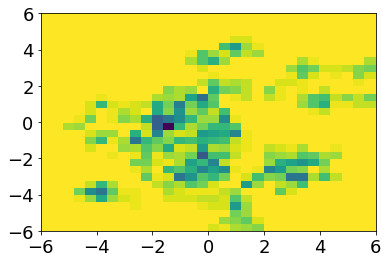

In [10]:


# algorithms

"""
# true_square_root = False: ALDI with nonsymmetric square root of C
def run_ALDI_with_gradient_mog(potential, N_sim, u0, tau, true_square_root = False, grad_inference = gradient_of_log_bimodal_distribution):
    
    d, J = u0.shape
    us_list_ALDI = np.zeros((d,J,N_sim))
    us_list_ALDI[:,:,0] = u0
    
    for n in range(N_sim-1):   
        
        us = us_list_ALDI[:,:,n]
        m_us = np.mean(us, axis=1)[:,np.newaxis]
        u_c = us - m_us 
        C = np.cov(us) * (J-1)/J 
        vs, _ = gradient_of_log_bimodal_distribution(us_list_ULA[:,:,n])
        
        drift = - np.dot(C,vs) + (d+1)*1/J*(us-m_us) 
        
        if not true_square_root: 
            Csqrt = 1/np.sqrt(J) * u_c
            noise = np.random.normal(0,1,(J,J))
            diff = np.sqrt(2)*Csqrt@noise
        
        else: 
            sqrtC = scipy.linalg.sqrtm(C)
            noise = np.random.normal(0,1,(2,J))
            diff = np.sqrt(2) * np.dot(sqrtC,noise)
        
    
        us_list_ALDI[:,:,n+1] = us + tau * drift  + np.sqrt(tau) * diff

    return us_list_ALDI


# our scheme. with true square root of D, also without the corrective term of Nuesken
def run_ALDINR_mog(potential, N_sim, u0, tau, const, grad_inference = gradient_of_log_bimodal_distribution):

    d, J = u0.shape    
    us_list_ALDINR = np.zeros((d,J,N_sim))
    us_list_ALDINR[:,:,0] = u0
    
    # to track the convergence
    #preconditioners = np.ones((d, d, N_sim)) # product of (D_opt+J_opt)K^{-1}
    #preconditioners[:, :, 0] = np.cov(u0)*(J-1)/J
    
    for n in range(N_sim-1): 
        
        us = us_list_ALDINR[:,:,n] # shape (d, J)
        m_us = np.mean(us, axis=1)[:,np.newaxis] # shape (2, 1)
        C = np.cov(us)*(J-1)/J # shape (2,2)

        # compute sqrt C
        sqrtC = scipy.linalg.sqrtm(C)
        
        # compute D
        D_opt_tilde, v, lambda_min = construct_D_opt_tilde(C,d)
        if lambda_min> 500:
            print("ALDINR diverging")
            
        D_opt = construct_D_opt(C,d)

        if np.mod(n, 500) == 0:
            print("iter")
            print(n)
            print("lambda min")
            print(lambda_min)
            #print(C)
            
        # compute psis
        psis = construct_onb(d, v)
        
        # compute sqrt D
        sqrtD = scipy.linalg.sqrtm(D_opt) # we should be able to do something cheap here
        
        # compute J opt
        J_opt = construct_J_opt(psis, v, lambda_min, const, d, sqrtC)
        
        T = J_opt +D_opt
        vs, _ = gradient_of_log_bimodal_distribution(us_list_ULA[:,:,n])
        
        drift = - np.dot(T, vs) 
        noise = np.random.normal(0,1,(2,J))
        diff = np.sqrt(2) * np.dot(sqrtD,noise) 
        
        
        us_list_ALDINR[:, :, n+1] = us + tau * drift  + np.sqrt(tau) * diff 
        
        # keep record of some stats
        #preconditioners[:, :, n] = T
        
    return us_list_ALDINR #, preconditioners
"""



I = potential

N_exp = 1

for j in range(N_exp):
    
    print()
    print("Experiment " +str(j))
    # resample initialization
    u0 = np.random.normal(0,2.0,(d,J)) 
    
    # ULA
    
    start_time = time.time()
    us_list_ULA = run_ULA_mog(I, N_sim, u0, tau)
    #np.save('save_data/mog/ULA_J_'+str(us_list_ULA.shape[1])+'_Nsim_'\
    #        +str(us_list_ULA.shape[2])+'_tau_'+str(tau)+'_Exp_'+str(j)+'.npy', us_list_ULA)
    print(f"ULA: {time.time()-start_time} seconds")

    name = nameof(us_list_ULA).lstrip('us_list')
    plot_results(I, us_list_ULA, tau, name, xmin =  -val, xmax = val, ymin = -val, ymax = val)
    plt.scatter(us_list_ULA[0, :, 0], us_list_ULA[1, :, 0],  color = "purple", label = 'initial')
    plt.scatter(us_list_ULA[0, :, -1], us_list_ULA[1, :, -1], color = "red", label = 'final')
    plt.show()
    
    """
    # ALDI 
    start_time = time.time()
    us_list_ALDI = run_ALDI_with_gradient_mog(I, N_sim, u0, tau)
    #np.save('save_data/mog/ALDI_J_'+str(us_list_ALDI.shape[1])+'_Nsim_'\
    #                    +str(us_list_ALDI.shape[2])+'_tau_'+str(tau)+'_Exp_'+str(j)+'.npy', us_list_ALDI)
    print(f"ALDI with gradient: {time.time()-start_time} seconds")
    
    name = nameof(us_list_ALDI).lstrip('us_list')
    plot_results(I, us_list_ALDI, tau, name, xmin =  -val, xmax = val, ymin = -val, ymax = val)
    plt.scatter(us_list_ALDI[0, :, 0], us_list_ALDI[1, :, 0], color = "purple", label = 'initial')
    plt.scatter(us_list_ALDI[0, :, -1], us_list_ALDI[1, :, -1], color = "red", label = 'final')
    plt.show()
    
    
    
    # NRALDI (our scheme)
    # eventually new parameters like stepsize

    tau_ALDINR = tau
    start_time = time.time()
    us_list_ALDINR = run_ALDINR_mog(I, N_sim, u0, tau_ALDINR, const) 
    #np.save('save_data/mog/ALDINR_J_'\
    #                      +str(us_list_ALDINR.shape[1])+'_Nsim_'+str(us_list_ALDINR.shape[2])+'_tau_'+str(tau_ALDINR)+'_Exp_'+str(j)+'.npy', us_list_ALDINR)
    print(f"ALDI NR: {time.time()-start_time} seconds")

    name = nameof(us_list_ALDINR).lstrip('us_list')
    plot_results(I, us_list_ALDINR, tau_ALDINR, name, xmin =  -val, xmax = val, ymin = -val, ymax = val)
    plt.scatter(us_list_ALDINR[0, :, 0], us_list_ALDINR[1, :, 0], color = "purple", label = 'initial')
    plt.scatter(us_list_ALDINR[0, :, -1], us_list_ALDINR[1, :, -1], color = "red", label = 'final')
    plt.legend()
    plt.show()
    """


### Mixture of Gaussians 2 

In [ ]:
# with a bigger gap we have to take a smaller stepsize

d = 2

y = np.zeros(1)
val = 6
xmin = -val
xmax = val
ymin= -val
ymax= val


# potential function
sigma = 1
gap = 8

#G = lambda u:  u[0] + u[1] # model
#Phi = lambda u: 0.5/(sigNoise**2)*(G(u)-y)**2 #likelihood

# potential function
nb_grid = 200
#m1 = - np.ones((2, nb_grid, nb_grid))
#m2 = np.ones((2, nb_grid, nb_grid))
#I1 = lambda u: 0.5/(sigma**2)*np.linalg.norm(np.subtract(u, m1),axis=0)**2 # TODO: recoder ça bien
#I2 = lambda u: 0.5/(sigma**2)*np.linalg.norm(np.subtract(u, m2),axis=0)**2 

m1 = np.asarray([-1, 0]).reshape((2,1))
m2 = np.asarray([1, 0]).reshape((2,1))

I1 = lambda u: 0.5/(sigma**2)*((u[0] - gap/2)**2 + u[1]**2) # TODO: recoder ça bien
I2 = lambda u: 0.5/(sigma**2)*((u[0] + gap/2)**2 + u[1]**2)

I = lambda u: - np.log(np.exp(-I1(u)) + np.exp(-I2(u)))


# plot posterior

u0s = np.linspace(xmin, xmax, nb_grid) # draw a grid of nb_grid points in 2d
u1s = np.linspace(ymin, ymax, nb_grid)
U = np.meshgrid(u0s,u1s)
#U = np.stack((U0,U1)) # size (2, nb_grid, nb_grid)

unnorm_dens = np.exp(-I1(U)) + np.exp(-I2(U))

Z = np.trapz(unnorm_dens, u0s, axis=1)
Z = np.trapz(Z, u1s)
dens = unnorm_dens/Z # check the computation
#dens = unnorm_dens

marg_over_x = np.trapz(dens, u0s, axis=1)
marg_over_y = np.trapz(dens, u1s, axis=0)

plt.figure()
DS = plt.contour(U0, U1, dens) # plot normalized density  
plt.clabel(DS, inline=1, fontsize=10)
labels = ['post', 'post','post','post','post', 'post']
for i in range(len(labels)):
    DS.collections[i].set_label(labels[i])
plt.axis('equal')

# parameters of all the algorithms

J = 20  # number of particles 
N_sim = 1000 # number of iterations
d = 2 # dimension
tau = 1e-3 # step size

# parameters of our algorithm
const = 1.5 



N_exp = 3

for j in range(N_exp):
    
    print()
    print("Experiment 1")
    # resample initialization
    u0 = np.random.normal(0,1.0,(d,J)) 


    # ULA
    start_time = time.time()
    us_list_ULA = run_ULA(I, N_sim, u0, tau)
    np.save('save_data/mog/ULA_J_'+str(us_list_ULA.shape[1])+'_Nsim_'\
            +str(us_list_ULA.shape[2])+'_tau_'+str(tau)+'_Exp_'+str(j)+'.npy', us_list_ULA)
    print(f"ULA: {time.time()-start_time} seconds")

    # ALDI 
    start_time = time.time()
    us_list_ALDI = run_ALDI_with_gradient(I, N_sim, u0, tau)
    np.save('save_data/mog/ALDI_J_'+str(us_list_ALDI.shape[1])+'_Nsim_'\
                        +str(us_list_ALDI.shape[2])+'_tau_'+str(tau)+'_Exp_'+str(j)+'.npy', us_list_ALDI)
    print(f"ALDI with gradient: {time.time()-start_time} seconds")

    # NRALDI (our scheme)
    # eventually new parameters like stepsize

    tau_ALDINR = tau
    start_time = time.time()
    us_list_ALDINR = run_ALDINR(I, N_sim, u0, tau_ALDINR, const) 
    np.save('save_data/mog/ALDINR_J_'\
                          +str(us_list_ALDINR.shape[1])+'_Nsim_'+str(us_list_ALDINR.shape[2])+'_tau_'+str(tau_ALDINR)+'_Exp_'+str(j)+'.npy', us_list_ALDINR)


    print(f"ALDI NR: {time.time()-start_time} seconds")
    
    # plot results
    
    val_min = min(( np.min(us_list_ULA), np.min(us_list_ALDI)))
    val_max = max(( np.max(us_list_ULA), np.max(us_list_ALDI)))

    name = nameof(us_list_ULA).lstrip('us_list')
    plot_results(I, us_list_ULA, tau, name, xmin =  -val, xmax = val, ymin = -val, ymax = val)
    plt.scatter(us_list_ULA[0, :, 0], us_list_ULA[1, :, 0],  color = "purple", label = 'initial')
    plt.scatter(us_list_ULA[0, :, -1], us_list_ULA[1, :, -1], color = "red", label = 'final')


    name = nameof(us_list_ALDI).lstrip('us_list')
    plot_results(I, us_list_ALDI, tau, name, xmin =  -val, xmax = val, ymin = -val, ymax = val)
    plt.scatter(us_list_ALDI[0, :, 0], us_list_ALDI[1, :, 0], color = "purple", label = 'initial')
    plt.scatter(us_list_ALDI[0, :, -1], us_list_ALDI[1, :, -1], color = "red", label = 'final')

    name = nameof(us_list_ALDINR).lstrip('us_list')
    plot_results(I, us_list_ALDINR, tau_ALDINR, name, xmin =  -val, xmax = val, ymin = -val, ymax = val)
    plt.scatter(us_list_ALDINR[0, :, 0], us_list_ALDINR[1, :, 0], color = "purple", label = 'initial')
    plt.scatter(us_list_ALDINR[0, :, -1], us_list_ALDINR[1, :, -1], color = "red", label = 'final')
    plt.legend()
    plt.show()



In [ ]:
# try again but a big step size but the computation of gradient log I is not nice
# it can diverge (but it can work very well and very fast as well - quitte ou double)

d = 2

y = np.zeros(1)
val = 6
xmin = -val
xmax = val
ymin= -val
ymax= val


# potential function
sigma = 1
gap = 8

#G = lambda u:  u[0] + u[1] # model
#Phi = lambda u: 0.5/(sigNoise**2)*(G(u)-y)**2 #likelihood

# potential function
nb_grid = 200
#m1 = - np.ones((2, nb_grid, nb_grid))
#m2 = np.ones((2, nb_grid, nb_grid))
#I1 = lambda u: 0.5/(sigma**2)*np.linalg.norm(np.subtract(u, m1),axis=0)**2 # TODO: recoder ça bien
#I2 = lambda u: 0.5/(sigma**2)*np.linalg.norm(np.subtract(u, m2),axis=0)**2 

m1 = np.asarray([-1, 0]).reshape((2,1))
m2 = np.asarray([1, 0]).reshape((2,1))

I1 = lambda u: 0.5/(sigma**2)*((u[0] - gap/2)**2 + u[1]**2) # TODO: recoder ça bien
I2 = lambda u: 0.5/(sigma**2)*((u[0] + gap/2)**2 + u[1]**2)

I = lambda u: - np.log(np.exp(-I1(u)) + np.exp(-I2(u)))


# plot posterior

u0s = np.linspace(xmin, xmax, nb_grid) # draw a grid of nb_grid points in 2d
u1s = np.linspace(ymin, ymax, nb_grid)
U = np.meshgrid(u0s,u1s)
#U = np.stack((U0,U1)) # size (2, nb_grid, nb_grid)

unnorm_dens = np.exp(-I1(U)) + np.exp(-I2(U))

Z = np.trapz(unnorm_dens, u0s, axis=1)
Z = np.trapz(Z, u1s)
dens = unnorm_dens/Z # check the computation
#dens = unnorm_dens

marg_over_x = np.trapz(dens, u0s, axis=1)
marg_over_y = np.trapz(dens, u1s, axis=0)

plt.figure()
DS = plt.contour(U0, U1, dens) # plot normalized density  
plt.clabel(DS, inline=1, fontsize=10)
labels = ['post', 'post','post','post','post', 'post']
for i in range(len(labels)):
    DS.collections[i].set_label(labels[i])
plt.axis('equal')

# parameters of all the algorithms

J = 20  # number of particles 
N_sim = 1000 # number of iterations
d = 2 # dimension
tau = 1e-2 # step size

# parameters of our algorithm
const = 1.5 



N_exp = 3

for j in range(N_exp):
    
    print()
    print("Experiment 1")
    # resample initialization
    u0 = np.random.normal(0,1.0,(d,J)) 


    # ULA
    start_time = time.time()
    us_list_ULA = run_ULA(I, N_sim, u0, tau)
    np.save('save_data/mog/ULA_J_'+str(us_list_ULA.shape[1])+'_Nsim_'\
            +str(us_list_ULA.shape[2])+'_tau_'+str(tau)+'_Exp_'+str(j)+'.npy', us_list_ULA)
    print(f"ULA: {time.time()-start_time} seconds")

    # ALDI 
    start_time = time.time()
    us_list_ALDI = run_ALDI_with_gradient(I, N_sim, u0, tau)
    np.save('save_data/mog/ALDI_J_'+str(us_list_ALDI.shape[1])+'_Nsim_'\
                        +str(us_list_ALDI.shape[2])+'_tau_'+str(tau)+'_Exp_'+str(j)+'.npy', us_list_ALDI)
    print(f"ALDI with gradient: {time.time()-start_time} seconds")

    # NRALDI (our scheme)
    # eventually new parameters like stepsize

    tau_ALDINR = tau
    start_time = time.time()
    us_list_ALDINR = run_ALDINR(I, N_sim, u0, tau_ALDINR, const) 
    np.save('save_data/mog/ALDINR_J_'\
                          +str(us_list_ALDINR.shape[1])+'_Nsim_'+str(us_list_ALDINR.shape[2])+'_tau_'+str(tau_ALDINR)+'_Exp_'+str(j)+'.npy', us_list_ALDINR)


    print(f"ALDI NR: {time.time()-start_time} seconds")
    
    # plot results
    
    val_min = min(( np.min(us_list_ULA), np.min(us_list_ALDI)))
    val_max = max(( np.max(us_list_ULA), np.max(us_list_ALDI)))

    name = nameof(us_list_ULA).lstrip('us_list')
    plot_results(I, us_list_ULA, tau, name, xmin =  -val, xmax = val, ymin = -val, ymax = val)
    plt.scatter(us_list_ULA[0, :, 0], us_list_ULA[1, :, 0],  color = "purple", label = 'initial')
    plt.scatter(us_list_ULA[0, :, -1], us_list_ULA[1, :, -1], color = "red", label = 'final')


    name = nameof(us_list_ALDI).lstrip('us_list')
    plot_results(I, us_list_ALDI, tau, name, xmin =  -val, xmax = val, ymin = -val, ymax = val)
    plt.scatter(us_list_ALDI[0, :, 0], us_list_ALDI[1, :, 0], color = "purple", label = 'initial')
    plt.scatter(us_list_ALDI[0, :, -1], us_list_ALDI[1, :, -1], color = "red", label = 'final')

    name = nameof(us_list_ALDINR).lstrip('us_list')
    plot_results(I, us_list_ALDINR, tau_ALDINR, name, xmin =  -val, xmax = val, ymin = -val, ymax = val)
    plt.scatter(us_list_ALDINR[0, :, 0], us_list_ALDINR[1, :, 0], color = "purple", label = 'initial')
    plt.scatter(us_list_ALDINR[0, :, -1], us_list_ALDINR[1, :, -1], color = "red", label = 'final')
    plt.legend()
    plt.show()



## Plot some statistics for ALDINR

In [ ]:
# choose one experiment that works, ie the first one (small gap big step size)

d = 2

y = np.zeros(1)
val = 6
xmin = -val
xmax = val
ymin= -val
ymax= val


# potential function
sigma = 1
gap = 4

#G = lambda u:  u[0] + u[1] # model
#Phi = lambda u: 0.5/(sigNoise**2)*(G(u)-y)**2 #likelihood

# potential function
nb_grid = 200
#m1 = - np.ones((2, nb_grid, nb_grid))
#m2 = np.ones((2, nb_grid, nb_grid))
#I1 = lambda u: 0.5/(sigma**2)*np.linalg.norm(np.subtract(u, m1),axis=0)**2 # TODO: recoder ça bien
#I2 = lambda u: 0.5/(sigma**2)*np.linalg.norm(np.subtract(u, m2),axis=0)**2 

m1 = np.asarray([-1, 0]).reshape((2,1))
m2 = np.asarray([1, 0]).reshape((2,1))

I1 = lambda u: 0.5/(sigma**2)*((u[0] - gap/2)**2 + u[1]**2) # TODO: recoder ça bien
I2 = lambda u: 0.5/(sigma**2)*((u[0] + gap/2)**2 + u[1]**2)

I = lambda u: - np.log(np.exp(-I1(u)) + np.exp(-I2(u)))


# plot posterior

u0s = np.linspace(xmin, xmax, nb_grid) # draw a grid of nb_grid points in 2d
u1s = np.linspace(ymin, ymax, nb_grid)
U = np.meshgrid(u0s,u1s)
#U = np.stack((U0,U1)) # size (2, nb_grid, nb_grid)

unnorm_dens = np.exp(-I1(U)) + np.exp(-I2(U))

Z = np.trapz(unnorm_dens, u0s, axis=1)
Z = np.trapz(Z, u1s)
dens = unnorm_dens/Z # check the computation
#dens = unnorm_dens

marg_over_x = np.trapz(dens, u0s, axis=1)
marg_over_y = np.trapz(dens, u1s, axis=0)

plt.figure()
DS = plt.contour(U0, U1, dens) # plot normalized density  
plt.clabel(DS, inline=1, fontsize=10)
labels = ['post', 'post','post','post','post', 'post']
for i in range(len(labels)):
    DS.collections[i].set_label(labels[i])
plt.axis('equal')

# parameters of all the algorithms

J = 20  # number of particles 
N_sim = 1000 # number of iterations
d = 2 # dimension
tau = 1e-2 # step size

# parameters of our algorithm
const = 1.5 


N_exp = 1

for j in range(N_exp):
    
    print()
    print("Experiment 1")
    # resample initialization
    u0 = np.random.normal(0,1.0,(d,J)) 


    # ULA
    start_time = time.time()
    us_list_ULA = run_ULA(I, N_sim, u0, tau)
    np.save('save_data/mog/ULA_J_'+str(us_list_ULA.shape[1])+'_Nsim_'\
            +str(us_list_ULA.shape[2])+'_tau_'+str(tau)+'_Exp_'+str(j)+'.npy', us_list_ULA)
    print(f"ULA: {time.time()-start_time} seconds")

    # ALDI 
    start_time = time.time()
    us_list_ALDI = run_ALDI_with_gradient(I, N_sim, u0, tau)
    np.save('save_data/mog/ALDI_J_'+str(us_list_ALDI.shape[1])+'_Nsim_'\
                        +str(us_list_ALDI.shape[2])+'_tau_'+str(tau)+'_Exp_'+str(j)+'.npy', us_list_ALDI)
    print(f"ALDI with gradient: {time.time()-start_time} seconds")

    # NRALDI (our scheme)
    # eventually new parameters like stepsize

    tau_ALDINR = tau
    start_time = time.time()
    us_list_ALDINR = run_ALDINR(I, N_sim, u0, tau_ALDINR, const) 
    np.save('save_data/mog/ALDINR_J_'\
                          +str(us_list_ALDINR.shape[1])+'_Nsim_'+str(us_list_ALDINR.shape[2])+'_tau_'+str(tau_ALDINR)+'_Exp_'+str(j)+'.npy', us_list_ALDINR)


    print(f"ALDI NR: {time.time()-start_time} seconds")
    
    # plot results
    
    val_min = min(( np.min(us_list_ULA), np.min(us_list_ALDI)))
    val_max = max(( np.max(us_list_ULA), np.max(us_list_ALDI)))

    name = nameof(us_list_ULA).lstrip('us_list')
    plot_results(I, us_list_ULA, tau, name, xmin =  -val, xmax = val, ymin = -val, ymax = val)
    plt.scatter(us_list_ULA[0, :, 0], us_list_ULA[1, :, 0],  color = "purple", label = 'initial')
    plt.scatter(us_list_ULA[0, :, -1], us_list_ULA[1, :, -1], color = "red", label = 'final')


    name = nameof(us_list_ALDI).lstrip('us_list')
    plot_results(I, us_list_ALDI, tau, name, xmin =  -val, xmax = val, ymin = -val, ymax = val)
    plt.scatter(us_list_ALDI[0, :, 0], us_list_ALDI[1, :, 0], color = "purple", label = 'initial')
    plt.scatter(us_list_ALDI[0, :, -1], us_list_ALDI[1, :, -1], color = "red", label = 'final')

    name = nameof(us_list_ALDINR).lstrip('us_list')
    plot_results(I, us_list_ALDINR, tau_ALDINR, name, xmin =  -val, xmax = val, ymin = -val, ymax = val)
    plt.scatter(us_list_ALDINR[0, :, 0], us_list_ALDINR[1, :, 0], color = "purple", label = 'initial')
    plt.scatter(us_list_ALDINR[0, :, -1], us_list_ALDINR[1, :, -1], color = "red", label = 'final')
    plt.legend()
    plt.show()



In [ ]:
# compute means and covariances

J = us_list_ULA.shape[1]
N_sim = us_list_ULA.shape[2]


means_ULA = np.mean(us_list_ULA, axis = 1)
means_ALDI = np.mean(us_list_ALDI, axis = 1)
means_ALDINR = np.mean(us_list_ALDINR, axis = 1)


covariances_ULA = np.ones((d, d, N_sim))
for i in range(N_sim):
    covariances_ULA[:,:, i] = np.cov(us_list_ULA[:, :, i])*(J-1)/J
 
covariances_ALDI = np.ones((d, d, N_sim))
for i in range(N_sim):
    covariances_ALDI[:,:, i] = np.cov(us_list_ALDI[:, :, i])*(J-1)/J

covariances_ALDINR = np.ones((d, d, N_sim))
for i in range(N_sim):
    covariances_ALDINR[:,:, i] = np.cov(us_list_ALDINR[:, :, i])*(J-1)/J

In [ ]:
distances_to_mean_ULA = np.linalg.norm(means_ULA, axis=0)
plt.plot(distances_to_mean_ULA, label = 'ULA' )

distances_to_mean_ALDI = np.linalg.norm(means_ALDI, axis=0)
plt.plot(distances_to_mean_ALDI, label = 'ALDI' )

distances_to_mean_ALDINR = np.linalg.norm(means_ALDINR, axis=0)
plt.plot(distances_to_mean_ALDINR, label = 'ALDINR')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Distance to mean (|| mean(particles) - mean(target)||)')

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3)
fig.set_figheight(7)
fig.set_figwidth(20)

plt.subplot(1, 2, 1)

plt.plot(means_ULA[0, :], label = 'ULA' )
plt.plot(means_ALDI[0, :], label = 'ALDI' )
plt.plot(means_ALDINR[0, :], label = 'ALDINR')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.axhline(y=0, color='r', linestyle='--', label ='true mean')
plt.title('Means of particles (1rst coordinate)')

plt.subplot(1, 2, 2)
plt.plot(means_ULA[1, :], label = 'ULA' )
plt.plot(means_ALDI[1, :], label = 'ALDI' )
plt.plot(means_ALDINR[1, :], label = 'ALDINR')
plt.axhline(y=0, color='r', linestyle='--', label ='true mean')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Means of particles (2nd coordinate)')
plt.tight_layout()

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3)
fig.set_figheight(7)
fig.set_figwidth(20)


average_means_ULA = np.asarray([np.mean(means_ULA[:, :i], axis = 1) for i in range(1, N_sim + 1)])
average_means_ALDI =  np.asarray([np.mean(means_ALDI[:, :i], axis = 1) for i in range(1, N_sim + 1)])
average_means_ALDINR = np.asarray([np.mean(means_ALDINR[:, :i], axis = 1) for i in range(1, N_sim + 1)])

plt.subplot(1, 2, 1)
plt.plot(average_means_ULA[:, 0], label = 'ULA' )
plt.plot(average_means_ALDI[:, 0], label = 'ALDI' )
plt.plot(average_means_ALDINR[:, 0], label = 'ALDINR')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.axhline(y=0, color='r', linestyle='--', label ='true mean')
plt.title('Average (over iterations) of the means of particles along iterations (1rst coordinate)')

plt.subplot(1, 2, 2)
plt.plot(average_means_ULA[:, 1], label = 'ULA' )
plt.plot(average_means_ALDI[:, 1], label = 'ALDI' )
plt.plot(average_means_ALDINR[:, 1], label = 'ALDINR')
plt.axhline(y=0, color='r', linestyle='--', label ='true mean')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Average (over iterations) of the means along iterations (2nd coordinate)')
plt.tight_layout()

In [ ]:
distances_to_covariances_ULA = np.asarray([np.linalg.norm(covariances_ULA[:, :, i]) for i in range(covariances_ULA.shape[2])])
plt.plot(distances_to_covariances_ULA, label ='ULA')

distances_to_covariances_ALDI = np.asarray([np.linalg.norm(covariances_ALDI[:, :, i]) for i in range(covariances_ALDI.shape[2])])
plt.plot(distances_to_covariances_ALDI, label ='ALDI')

distances_to_covariances_ALDINR = np.asarray([np.linalg.norm(covariances_ALDINR[:, :, i]) for i in range(covariances_ALDINR.shape[2])])
plt.plot(distances_to_covariances_ALDINR, label ='ALDINR')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Norm of C along iter')
plt.show()

In [ ]:
traces_of_C_ULA = np.asarray([np.trace(covariances_ULA[:, :, i]) for  i in range(covariances_ULA.shape[2])] )
traces_of_C_ALDI = np.asarray([np.trace(covariances_ALDI[:, :, i]) for  i in range(covariances_ALDI.shape[2])] )
traces_of_C_ALDINR = np.asarray([np.trace(covariances_ALDINR[:, :, i]) for  i in range(covariances_ALDINR.shape[2])] )

plt.plot(traces_of_C_ULA, label ='ULA')
plt.plot(traces_of_C_ALDI, label ='ALDI')
plt.plot(traces_of_C_ALDINR, label ='ALDINR')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Trace of C along ALDINR')
plt.show()

### marginal of distribution of particles on last iterations

In [ ]:
binsx = np.linspace(xmin,xmax,31)
binsy = np.linspace(ymin,ymax,31)

# marginal over x

fig, axes = plt.subplots(nrows=1, ncols=3)
fig.set_figheight(5)
fig.set_figwidth(10)

plt.subplot(1,3,1)
plt.plot(u0s, marg_over_x)
plt.hist(us_list_ULA[0,:,0:].flatten(), density=True)
plt.plot(u0s, marg_over_x, color = 'red')
plt.title('marginal over x - ULA')

plt.subplot(1,3,2)
plt.plot(u0s, marg_over_x)
plt.hist(us_list_ALDI[0,:,0:].flatten(), density=True)
plt.plot(u0s, marg_over_x, color = 'red')
plt.title('marginal over x - ALDI')

plt.subplot(1,3,3)
plt.plot(u0s, marg_over_x)
plt.hist(us_list_ALDINR[0,:,0:].flatten(), density=True)
plt.plot(u0s, marg_over_x, color = 'red')
plt.title('marginal over x - ALDINR')
fig.tight_layout()

# marginal over y

fig, axes = plt.subplots(nrows=1, ncols=3)
fig.set_figheight(5)
fig.set_figwidth(10)

plt.subplot(1,3,1)
plt.plot(u0s, marg_over_y)
plt.hist(us_list_ULA[0,:,0:].flatten(), density=True)
plt.plot(u0s, marg_over_y, color = 'red')
plt.title('marginal over y - ULA')

plt.subplot(1,3,2)
plt.plot(u0s, marg_over_y)
plt.hist(us_list_ALDI[0,:,0:].flatten(), density=True)
plt.plot(u0s, marg_over_y, color = 'red')
plt.title('marginal over y - ALDI')

plt.subplot(1,3,3)
plt.plot(u0s, marg_over_y)
plt.hist(us_list_ALDINR[0,:,0:].flatten(), density=True)
plt.plot(u0s, marg_over_y, color = 'red')
plt.title('marginal over y - ALDINR')
plt.tight_layout()

In [ ]:
j = 0

# load data

# compute means and covariances
J = us_list_ULA.shape[1]
N_sim = us_list_ULA.shape[2]


means_ULA = np.mean(us_list_ULA, axis = 1)
means_ALDI = np.mean(us_list_ALDI, axis = 1)
means_ALDINR = np.mean(us_list_ALDINR, axis = 1)

covariances_ULA = np.ones((d, d, N_sim))
for i in range(N_sim):
    covariances_ULA[:,:, i] = np.cov(us_list_ULA[:, :, i])*(J-1)/J
 
covariances_ALDI = np.ones((d, d, N_sim))
for i in range(N_sim):
    covariances_ALDI[:,:, i] = np.cov(us_list_ALDI[:, :, i])*(J-1)/J

covariances_ALDINR = np.ones((d, d, N_sim))
for i in range(N_sim):
    covariances_ALDINR[:,:, i] = np.cov(us_list_ALDINR[:, :, i])*(J-1)/J
    
# plot distances to target mean
distances_to_mean_ULA = np.linalg.norm(means_ULA, axis=0)
plt.plot(distances_to_mean_ULA, label = 'ULA' )

distances_to_mean_ALDI = np.linalg.norm(means_ALDI, axis=0)
plt.plot(distances_to_mean_ALDI, label = 'ALDI' )

distances_to_mean_ALDINR = np.linalg.norm(means_ALDINR, axis=0)
plt.plot(distances_to_mean_ALDINR, label = 'ALDINR')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Distance to mean (|| mean(particles) - mean(target)||)')

# plot means of particles along iterations

fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_figheight(7)
fig.set_figwidth(20)

plt.subplot(1, 2, 1)
plt.plot(means_ULA[0, :], label = 'ULA' )
plt.plot(means_ALDI[0, :], label = 'ALDI' )
plt.plot(means_ALDINR[0, :], label = 'ALDINR')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.axhline(y=0, color='r', linestyle='--', label ='true mean')
plt.title('Means of particles (1rst coordinate)')

plt.subplot(1, 2, 2)
plt.plot(means_ULA[1, :], label = 'ULA' )
plt.plot(means_ALDI[1, :], label = 'ALDI' )
plt.plot(means_ALDINR[1, :], label = 'ALDINR')
plt.axhline(y=0, color='r', linestyle='--', label ='true mean')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Means of particles (2nd coordinate)')
plt.tight_layout()
plt.show()

# plot historical average (i.e. over iterations) of means of particles

average_means_ULA = np.asarray([np.mean(means_ULA[:, :i], axis = 1) for i in range(1, N_sim + 1)])
average_means_ALDI =  np.asarray([np.mean(means_ALDI[:, :i], axis = 1) for i in range(1, N_sim + 1)])
average_means_ALDINR = np.asarray([np.mean(means_ALDINR[:, :i], axis = 1) for i in range(1, N_sim + 1)])

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
#fig.set_figheight(7)
#fig.set_figwidth(20)

plt.subplot(1, 2, 1)
plt.plot(average_means_ULA[:, 0], label = 'ULA' )
plt.plot(average_means_ALDI[:, 0], label = 'ALDI' )
plt.plot(average_means_ALDINR[:, 0], label = 'ALDINR')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.axhline(y=0, color='r', linestyle='--', label ='true mean')
plt.title('Historical average of the means of particles (1rst coordinate)')

plt.subplot(1, 2, 2)
plt.plot(average_means_ULA[:, 1], label = 'ULA' )
plt.plot(average_means_ALDI[:, 1], label = 'ALDI' )
plt.plot(average_means_ALDINR[:, 1], label = 'ALDINR')
plt.axhline(y=0, color='r', linestyle='--', label ='true mean')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Historical average of the means of particles (2nd coordinate)')
plt.tight_layout()
plt.show()

distances_to_covariances_ULA = np.asarray([np.linalg.norm(covariances_ULA[:, :, i]) for i in range(covariances_ULA.shape[2])])
plt.plot(distances_to_covariances_ULA, label ='ULA')

distances_to_covariances_ALDI = np.asarray([np.linalg.norm(covariances_ALDI[:, :, i]) for i in range(covariances_ALDI.shape[2])])
plt.plot(distances_to_covariances_ALDI, label ='ALDI')

distances_to_covariances_ALDINR = np.asarray([np.linalg.norm(covariances_ALDINR[:, :, i]) for i in range(covariances_ALDINR.shape[2])])
plt.plot(distances_to_covariances_ALDINR, label ='ALDINR')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Norm of C-K along iter')
plt.show()